## Worksheet 06

In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Understanding and Visualization

In [3]:
dataset_url = '/content/drive/MyDrive/AIML/Workshop_5/FruitinAmazon'  # Replace with your actual path in Google Drive
base_dir = dataset_url
train_folder = os.path.join(base_dir, 'train')
test_folder = os.path.join(base_dir, 'test')

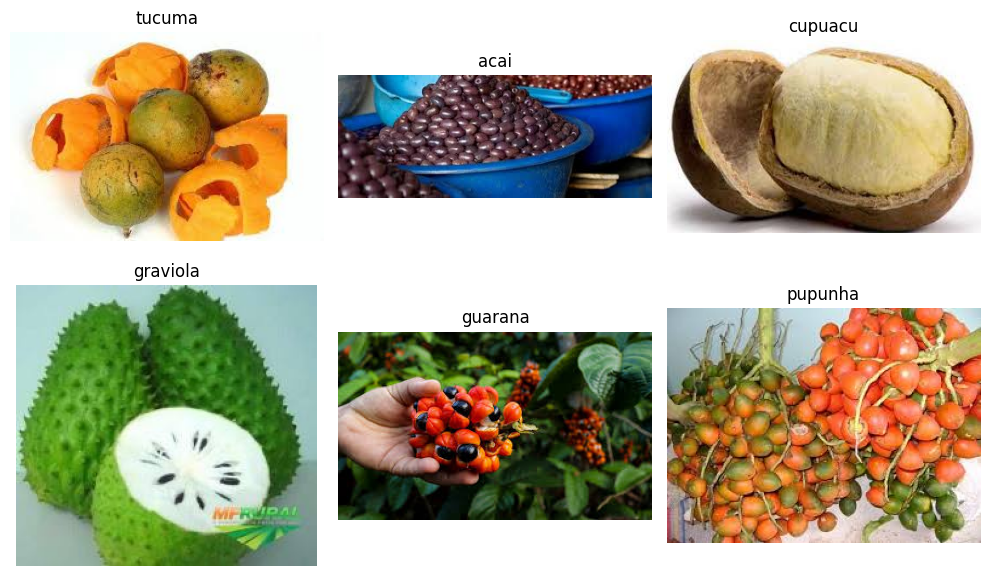

In [4]:
# Get the list of class directories
class_names = [d for d in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, d))]

# Select one random image from each class
selected_images = []
for class_name in class_names:
    class_path = os.path.join(train_folder, class_name)
    images = os.listdir(class_path)

    # Randomly select one image
    if images:
        selected_image = random.choice(images)
        selected_images.append((class_name, os.path.join(class_path, selected_image)))

# Display images in a grid with two rows
num_classes = len(selected_images)
cols = (num_classes + 1) // 2  # Number of columns in the grid

fig, axes = plt.subplots(2, cols, figsize=(10, 6))
axes = axes.flatten()  # Flatten for easy indexing

for i, (class_name, image_path) in enumerate(selected_images):
    img = mpimg.imread(image_path)  # Load image
    axes[i].imshow(img)  # Show image
    axes[i].set_title(class_name)  # Set title
    axes[i].axis("off")  # Hide axes

# Hide unused axes if any
for i in range(len(selected_images), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

*What did you observe?*


Since the selection is random, running the script several times gives a different image each time.

The script chooses one class directory from the dataset randomly. It then chooses one picture from the chosen class at random. The name and path of the image are printed.

In [5]:
# List to keep track of corrupted images
corrupted_images = []

# Iterate through each class subdirectory
for class_name in os.listdir(train_folder):
    class_path = os.path.join(train_folder, class_name)

    if os.path.isdir(class_path):  # Ensure it's a directory
        # Iterate through each image file in the class folder
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:
                # Try opening the image
                with Image.open(image_path) as img:
                    img.verify()  # Verify if the image is valid
            except (IOError, SyntaxError):
                # If an error occurs, it means the image is corrupted
                corrupted_images.append(image_path)
                os.remove(image_path)  # Remove the corrupted image
                print(f"Removed corrupted image: {image_path}")

# Check if any corrupted images were found
if not corrupted_images:
    print("No corrupted images found.")
else:
    print(f"Total corrupted images removed: {len(corrupted_images)}")


No corrupted images found.


# Loading and Preprocessing Image Data in keras

In [6]:
# Define image size and batch size
img_height = 128 # Example image height
img_width = 128 # Example image width
batch_size = 32
validation_split = 0.2 # 80% training, 20% validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
     train_folder, labels='inferred',
     label_mode='int',
     image_size=(img_height, img_width),
     interpolation='nearest',
     batch_size= batch_size,
     shuffle=True,
     validation_split=validation_split,
     subset='training',
     seed=123
)

Found 90 files belonging to 6 classes.
Using 72 files for training.


In [7]:

# Define image size and batch size
img_height = 128 # Example image height
img_width = 128 # Example image width
batch_size = 32
validation_split = 0.2 # 80% training, 20% validation

rescale = tf.keras.layers.Rescaling(1./255) # Normalize pixel values to [0, 1]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)
# Apply the normalization (Rescaling) to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
# Create validation dataset with normalization
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)
# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


#Data augmentation

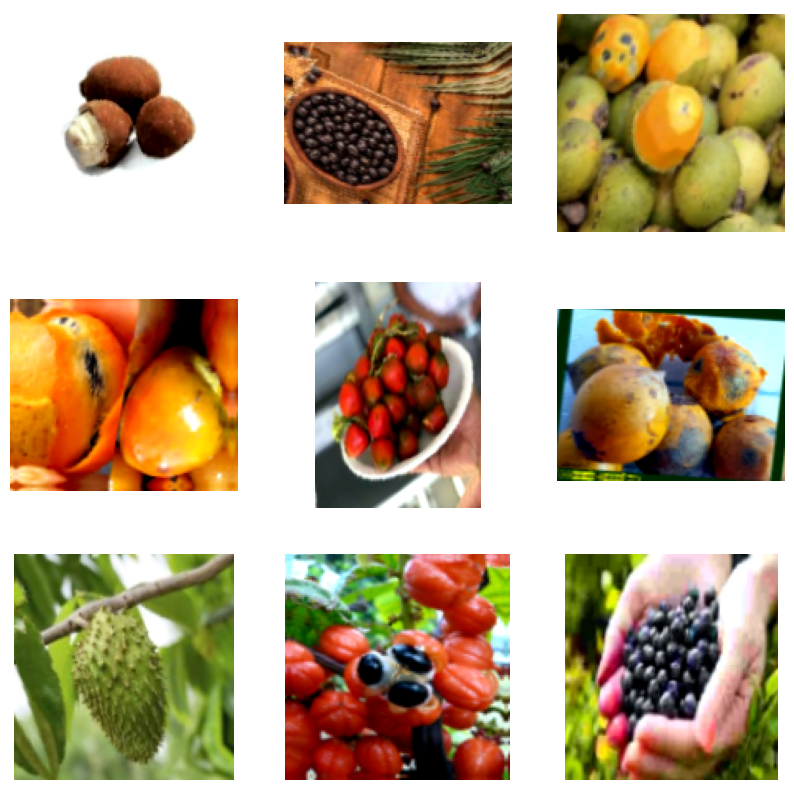

In [8]:


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
    layers.RandomContrast(0.3),
])


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented = data_augmentation(tf.expand_dims(images[i], axis=0), training=True)
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.clip_by_value(augmented[0], 0, 1).numpy())
        plt.axis("off")
plt.show()


In [9]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)  # Prints (batch_size, height, width, channels)
    break

(32, 128, 128, 3)


In [10]:
input_shape = (32, 128, 128, 3)

# Finding image shape

In [11]:
from tensorflow.keras.layers import BatchNormalization
layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
beta_initializer="zeros", gamma_initializer="ones")

In [12]:
from tensorflow.keras.layers import Dropout
layer = Dropout(rate=0.25, noise_shape=None, seed=None)

# Implementing CNN Model

In [13]:
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

num_classes = len(class_names)

# Define the model
model = models.Sequential([

    layers.Conv2D(32, (3, 3), padding='same', activation=None, input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),


    layers.Conv2D(64, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),


    layers.Flatten(),

    # Fully Connected Layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),

    # Output Layer
    layers.Dense(10, activation='softmax')  # Assuming 10 classes
])


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,409,802 (32.08 MB)

 Trainable params: 8,409,610 (32.08 MB)

 Non-trainable params: 192 (768.00 B)

In [14]:
inputs = keras.Input(shape=input_shape)

# Compile the model
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
checkpoint_cb = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=8,
    epochs=200,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2000
)

model.summary()

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0799 - loss: 10.1099

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.0807 - loss: 11.4859 - val_accuracy: 0.0000e+00 - val_loss: 7.1004
Epoch 2/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1484 - loss: 62.3875

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.1576 - loss: 56.5343 - val_accuracy: 0.0000e+00 - val_loss: 2.3111
Epoch 3/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.2031 - loss: 2.1485

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - accuracy: 0.2057 - loss: 2.1785 - val_accuracy: 0.1111 - val_loss: 2.2904
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.1319 - loss: 2.2552 - val_accuracy: 0.0000e+00 - val_loss: 2.5121
Epoch 5/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.1172 - loss: 3.1640

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.1350 - loss: 2.9765 - val_accuracy: 0.0000e+00 - val_loss: 2.2081
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.1801 - loss: 2.3347 - val_accuracy: 0.0556 - val_loss: 2.2649
Epoch 7/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0859 - loss: 2.2695 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.0985 - loss: 2.2641 - val_accuracy: 0.0556 - val_loss: 2.1690
Epoch 8/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2969 - loss: 2.0571

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.2734 - loss: 2.0702 - val_accuracy: 0.3889 - val_loss: 2.1139
Epoch 9/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2578 - loss: 2.0824 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.2609 - loss: 2.0743 - val_accuracy: 0.0000e+00 - val_loss: 2.0779
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2335 - loss: 2.4706 - val_accuracy: 0.0000e+00 - val_loss: 2.3695
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.2383 - loss: 2.1847 - val_accuracy: 0.0000e+00 - val_loss: 2.1403
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2413 - loss: 2.0722 - val_accuracy: 0.3889 - val_loss: 2.1804
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3043 - loss: 1.7829 - val_accuracy: 0.0000e+00 - val_loss: 2.2583
Epoch 14/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2344 - loss: 1.9514 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.2630 - loss: 1.9054 - val_accuracy: 0.8333 - val_loss: 1.7752
Epoch 15/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.1745 - loss: 3.4383 - val_accuracy: 0.0000e+00 - val_loss: 2.2326
Epoch 16/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.3129 - loss: 1.6782 - val_accuracy: 0.1111 - val_loss: 2.1159
Epoch 17/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3394 - loss: 1.6232 - val_accuracy: 0.7222 - val_loss: 1.9735
Epoch 18/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3563 - loss: 1.5278 - val_accuracy: 0.0000e+00 - val_loss: 2.1233
Epoch 19/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4375 - loss: 1.4333 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.4271 - loss: 1.4560 - val_accuracy: 0.8333 - val_loss: 1.6904
Epoch 20/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.2374 - loss: 1.8105 - val_accuracy: 0.0000e+00 - val_loss: 2.0868
Epoch 21/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.3681 - loss: 1.4861 - val_accuracy: 0.7778 - val_loss: 1.9122
Epoch 22/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3867 - loss: 1.5240 - val_accuracy: 0.0000e+00 - val_loss: 2.0547
Epoch 23/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3681 - loss: 1.5674 - val_accuracy: 0.0000e+00 - val_loss: 2.0146
Epoch 24/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3181 - loss: 1.6114 - val_accuracy: 0.6667 - val_loss: 1.8434
Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2648 - loss: 2.0106 - val_accuracy: 0.1111 - val_loss: 2.0568
Epoch 2/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.2257 - loss: 2.1865 - val_accuracy: 0.8333 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,409,804 (32.08 MB)

 Trainable params: 8,409,610 (32.08 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

# Evaluating the model

In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder, labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size= batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
  )

Found 30 files belonging to 6 classes.
Using 24 files for training.


In [16]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2917 - loss: 1694.4507
Test Loss: 1694.4507
Test Accuracy: 0.2917


# Save and load the model

In [17]:
# Save the model
model.save('trained_model.h5')

# Load the model
loaded_model = keras.models.load_model('trained_model.h5')

# Re-evaluate the model on the test set
test_loss, test_accuracy = loaded_model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step - accuracy: 0.2917 - loss: 1694.4506
Test Loss: 1694.4506
Test Accuracy: 0.2917


# Predictions and Classification reports

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
              precision    recall  f1-score   support

      tucuma       0.20      0.25      0.22         4
        acai       0.27      0.75      0.40         4
     cupuacu       0.67      0.50      0.57         4
    graviola       0.00      0.00      0.00         3
     guarana       0.00      0.00      0.00         5
     pupunha       0.20      0.25      0.22         4

    accuracy                           0.29        24
   macro avg       0.22      0.29      0.24        24
weighted avg       0.22      0.29      0.24        24



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


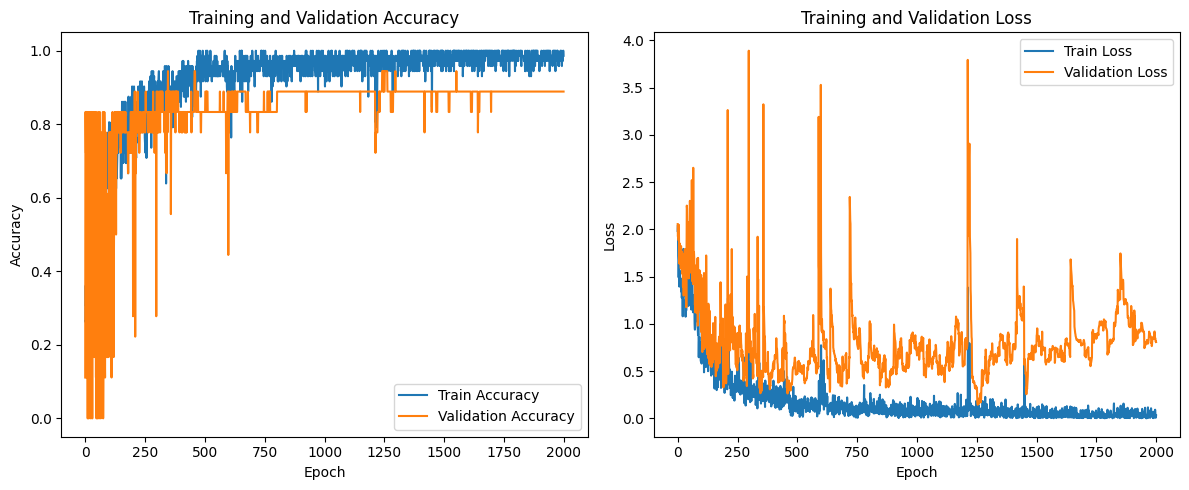

In [18]:
import numpy as np
from sklearn.metrics import classification_report

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    predictions = loaded_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [19]:
from tensorflow.keras.applications import VGG16

# Load VGG16 without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers so their weights won't change during training
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)           # Flatten the output
x = Dense(1024, activation='relu')(x)     # Fully connected layer
outputs = Dense(10, activation='softmax')(x)  # Output layer (10 classes)

# Create the full model
model = Model(inputs=base_model.input, outputs=outputs)


In [21]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',  # Change to 'categorical_crossentropy' if needed
    metrics=['accuracy']
)


In [22]:
# If using image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder,
    image_size=(224, 224),
    batch_size=32
)


Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.


In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping]
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1976 - loss: 6.9007   

3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 11s/step - accuracy: 0.2065 - loss: 6.6092 - val_accuracy: 0.4000 - val_loss: 3.4872
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step - accuracy: 0.6753 - loss: 1.4148 - val_accuracy: 0.5667 - val_loss: 2.5355
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step - accuracy: 0.8363 - loss: 0.5426 - val_accuracy: 0.6667 - val_loss: 1.2786
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step - accuracy: 0.9944 - loss: 0.0348 - val_accuracy: 0.6000 - val_loss: 1.5288
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.9944 - loss: 0.0221 - val_accuracy: 0.5667 - val_loss: 2.1944
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.9827 - loss: 0.0259 - val_accuracy: 0.6333 - val_loss: 2.4801


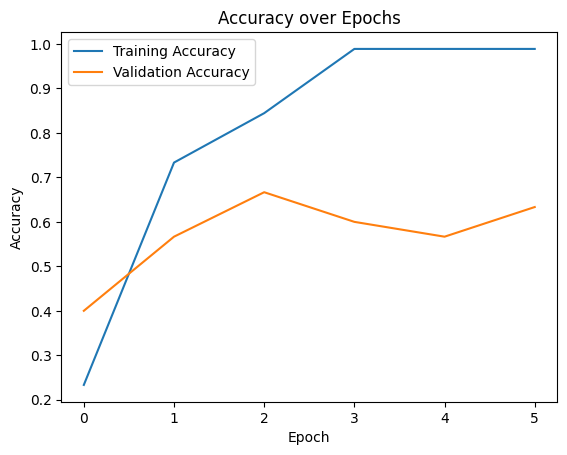

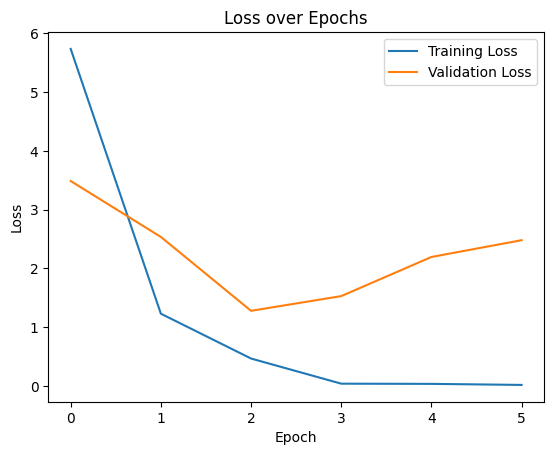

In [24]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
